In [ ]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import networkx as nx

import matplotlib.pyplot as plt

In [ ]:
# установить spacy модель
NER = spacy.load("en_core_web_sm")
print(NER.max_length)

1000000


### Загрузка книги



In [ ]:
book = 'AK.txt'
book_text = open(book, encoding="utf8").read()
NER.max_length = len(book_text) + 100
book_doc = NER(book_text)

In [ ]:
displacy.render(book_doc[:1000], style="ent", jupyter=True)

### Загружаем имена героев

In [ ]:
character_df = pd.read_csv("AK_characters.csv")

In [ ]:
character_df.head(50)

,FIRST,SECOND,THIRD,FOURTH,FIFTH
0,Stiva,Stepan Arkadyevich,Stepan Oblonsky,Stepan Arkadyevich Oblonsky,Stepan
1,Dolly,Darya Alexandrovna,Darya Oblonskaya,Darya Alexandrovna Oblonskaya,Darya
2,Tanya,/,/,/,/
3,Grisha,/,/,/,/
4,Lily,/,/,/,/
5,Princess Varvara,Varvara,/,/,/
6,Princess Katerina Pavlovna,Katerina Pavlovna,Katerina,/,/
7,Prince Peter Oblonsky,Peter Oblonsky,Peter,/,/
8,Matvei,/,/,/,/
9,Matryona Filimonovna,Matryona,/,/,/


Пройдемся по книге по предложениям и составим список сущностей для каждого предложения


In [ ]:
sent_entity_df = []

# для каждого предложения создаем список сущностей
for sent in book_doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({"предложение": sent, "сущность": entity_list})

sent_entity_df = pd.DataFrame(sent_entity_df)

In [ ]:
sent_entity_df.head(150)

,предложение,сущность
0,"(﻿PART, ONE, \n\n, Chapter, 1, \n\n\n, Happy, ...",[Chapter 1\n\n\n]
1,"(Everything, was, in, confusion, in, the, Oblo...",[Oblonskys]
2,"(The, wife, had, \n, discovered, that, the, hu...",[French]
3,"(This, position, of, affairs, had, now, lasted...",[three days]
4,"(Every, person, in, the, \n, house, felt, that...",[Oblonskys]
...,...,...
145,"(The, liberal, party, said, that, marriage, is...",[Stepan Arkadyevitch]
146,"(The, liberal, \n, party, said, ,, or, rather,...",[Stepan Arkadyevitch]
147,"(And, with, all, this, ,, \n, Stepan, Arkadyev...","[Stepan Arkadyevitch, Rurik, first]"
148,"(And, so, \n, Liberalism, had, become, a, habi...","[Liberalism, Stepan Arkadyevitch’s]"


In [ ]:
# Функция фильтрации сущностей, которые не являются героями
def filter_entity(ent_list, character_df):
    return [ent for ent in ent_list
            if ent in list(character_df.FIRST)
            or ent in list(character_df.SECOND)
            or ent in list(character_df.THIRD)
            or ent in list(character_df.FOURTH)
            or ent in list(character_df.FIFTH)
            ]

In [ ]:
# создается новый столбец
sent_entity_df['сущности_персонажей'] = sent_entity_df['сущность'].apply(lambda x: filter_entity(x, character_df))

# удаляем пустые
sent_entity_df_filtered = sent_entity_df[sent_entity_df['сущности_персонажей'].map(len) > 0]
sent_entity_df_filtered

,предложение,сущность,сущности_персонажей
7,"(Three, days, after, the, quarrel, ,, Prince, ...","[Three days, Stiva, eight o’clock in the morning]",[Stiva]
12,"(Alabin, was, giving, a, dinner, at, Darmstadt...","[Alabin, Darmstadt, Darmstadt, American]",[Alabin]
14,"(Yes, ,, Alabin, was, giving, a, dinner, on, g...",[Alabin],[Alabin]
33,"(She, ,, his, Dolly, ,, forever, fussing, and,...",[Dolly],[Dolly]
69,"((, He, vividly, recalled, the, roguish, \n, b...",[Mlle],[Mlle]
...,...,...,...
19800,"(Levin, listened, to, the, monotonous, drip, f...",[Levin],[Levin]
19803,"(Levin, said, to, himself, ,, feeling, \n, bef...",[Levin],[Levin]
19821,"(he, heard, Kitty, ’s, voice, all, at, once, ,...",[Kitty],[Kitty]
19831,"(“, Kostya, !, do, something, for, me, ,, ”, s...","[Kostya, Sergey Ivanovitch]",[Kostya]


### Создаем связи

In [ ]:
window_size = 5 # размер окна связи в предложениях
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i + 5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].сущности_персонажей), [])

    # удаляем дублирующиеся связи
    char_unique = [char_list[i] for i in range(len(char_list))
                   if (i==0) or char_list[i] != char_list[i-1]]

    # те персонажи, которые появляются рядом друг с другом (в 5 предложениях),  образуют связь
    if len(char_unique) > 1: # если список из уникальных персонажей равен 1, то естественно нет связи
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

relationship_df = pd.DataFrame(relationships)
relationship_df

,source,target
0,Stiva,Alabin
1,Mlle,Roland
2,Mlle,Roland
3,Mlle,Roland
4,Mlle,Roland
...,...,...
12030,Kitty,Katavasov
12031,Katavasov,Levin
12032,Kostya,Levin
12033,Kostya,Levin


In [ ]:
# объединим воедино все дублирующиеся взаимосвязи - создадим ВЕС связи
# вначале сортируем связи типа a->b и b->a, ведь это одна связь
relationship_df = pd.DataFrame(np.sort(relationship_df.values, axis = 1), columns = relationship_df.columns)
relationship_df

,source,target
0,Alabin,Stiva
1,Mlle,Roland
2,Mlle,Roland
3,Mlle,Roland
4,Mlle,Roland
...,...,...
12030,Katavasov,Kitty
12031,Katavasov,Levin
12032,Kostya,Levin
12033,Kostya,Levin


In [ ]:
relationship_df["value"] = 1 # вес связи (или ребра)
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum() # группировка и суммирование
relationship_df

,source,target,value
0,Alabin,Stiva,1
1,Mlle,Roland,5
2,Grisha,Tanya,63
3,Miss Hoole,Tanya,5
4,Anna,Karenin,29
...,...,...,...
385,Kant,Schopenhauer,6
386,Levin,Schopenhauer,2
387,Katavasov,Tanya,17
388,Katavasov,Spencer,2


In [ ]:
relationship_df.to_excel('relationship.xlsx',index=False)

### Визуализация графа и его анализ


In [ ]:
relationship_df = pd.read_excel('relationship.xlsx')

In [ ]:
relationship_df

,source,target,value
0,Alabin,Stiva,1
1,Grisha,Tanya,63
2,Miss Hoole,Tanya,5
3,Anna,Karenin,31
4,Kitty,Levin,1352
...,...,...,...
289,Kant,Schopenhauer,6
290,Levin,Schopenhauer,2
291,Katavasov,Tanya,17
292,Katavasov,Spencer,2


Визуализация с помощью NetworkX (плохой вариант)

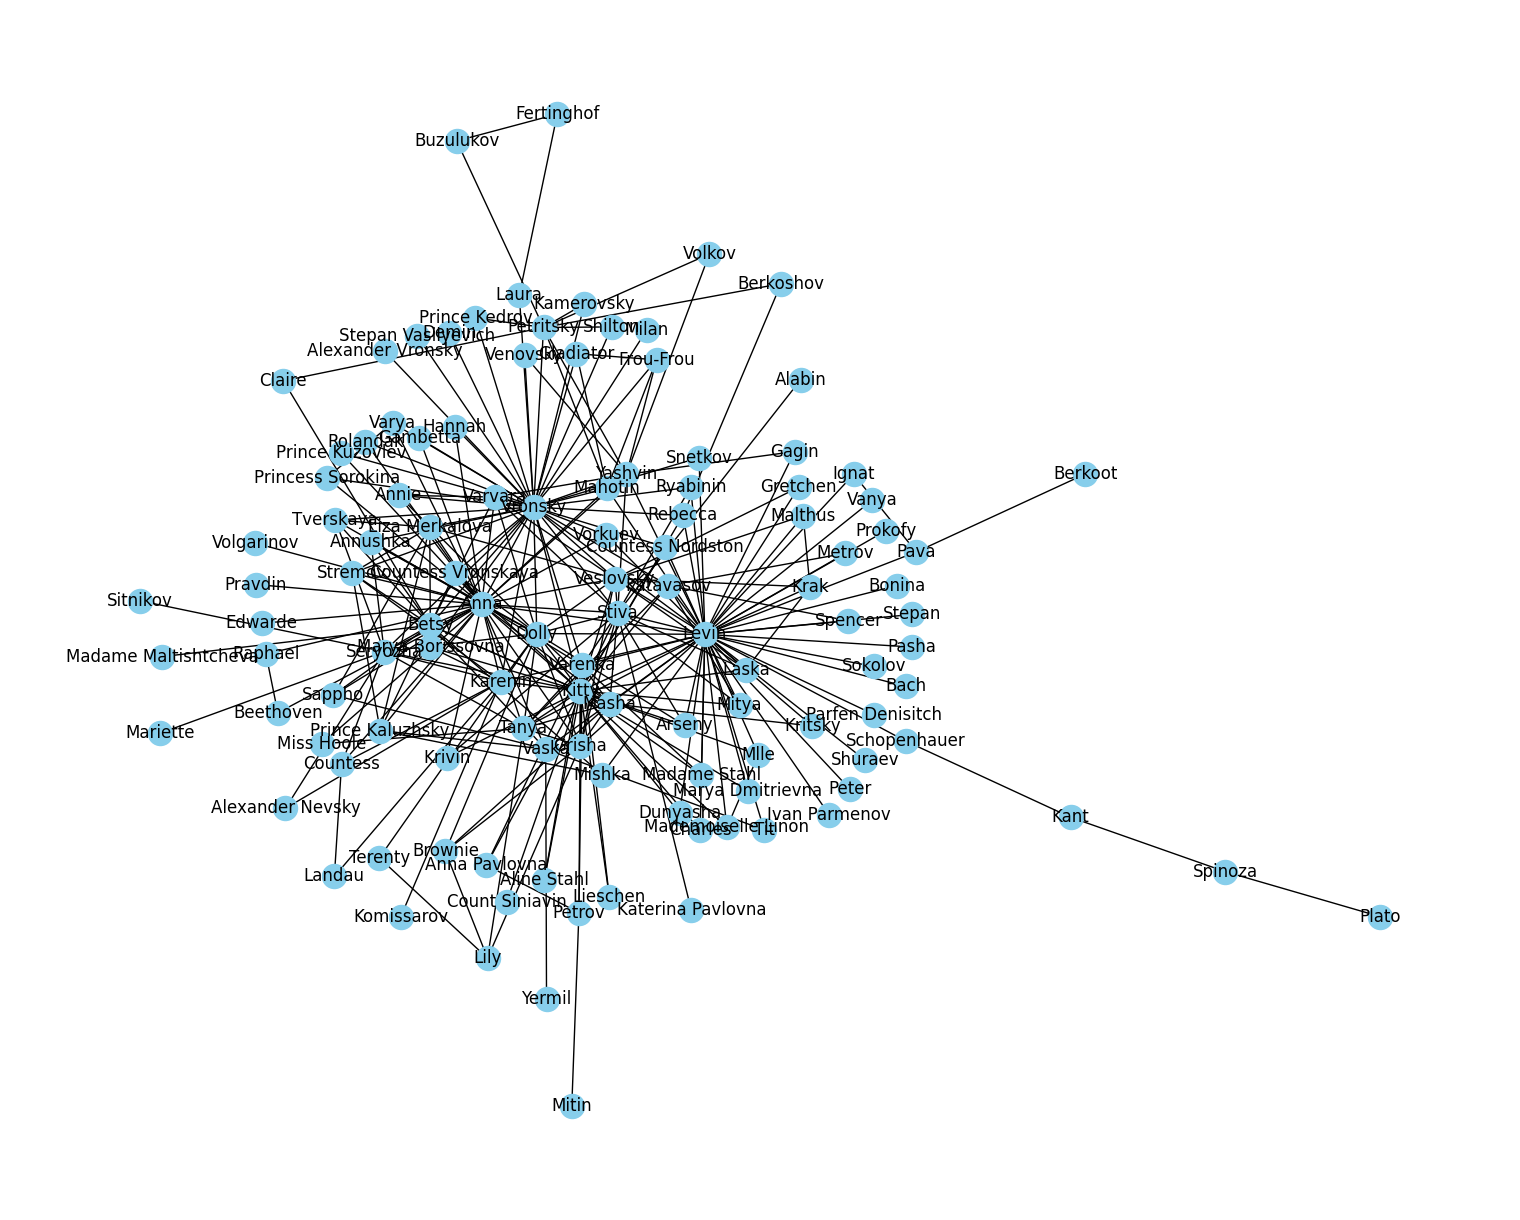

In [ ]:
G = nx.from_pandas_edgelist(relationship_df,
                            source = "source",
                            target = "target",
                            edge_attr = "value",
                            create_using = nx.Graph())
plt.figure(figsize=(15,12))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

Визуализация с помощью Pyvis

In [ ]:
!pip install pyvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 62.3 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network

net = Network(notebook = True, bgcolor='#222222', font_color='white',cdn_resources='remote', width="1400px", height="1000px")

# Определяем размер вершины по степени её связи
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G)
net.show("AK.html")

AK.html


### Выделяем сообщества


In [ ]:
import community.community_louvain as community_louvain
communities = community_louvain.best_partition(G) #, weight='value',resolution=0.5)
communities

{'Alabin': 1,
 'Stiva': 1,
 'Grisha': 1,
 'Tanya': 1,
 'Miss Hoole': 2,
 'Anna': 2,
 'Karenin': 3,
 'Kitty': 4,
 'Levin': 5,
 'Dolly': 1,
 'Mademoiselle Linon': 4,
 'Mlle': 4,
 'Stepan': 5,
 'Bonina': 5,
 'Vronsky': 0,
 'Countess Nordston': 4,
 'Masha': 1,
 'Countess Vronskaya': 4,
 'Seryozha': 3,
 'Krivin': 1,
 'Prokofy': 5,
 'Kritsky': 1,
 'Vanya': 5,
 'Ignat': 5,
 'Pava': 5,
 'Laska': 5,
 'Berkoot': 5,
 'Annushka': 3,
 'Mariette': 3,
 'Pravdin': 2,
 'Raphael': 2,
 'Beethoven': 2,
 'Petritsky': 0,
 'Shilton': 0,
 'Kamerovsky': 0,
 'Rebecca': 0,
 'Berkoshov': 0,
 'Laura': 0,
 'Fertinghof': 0,
 'Buzulukov': 0,
 'Betsy': 2,
 'Tverskaya': 2,
 'Prince Kedrov': 0,
 'Claire': 0,
 'Madame Maltishtcheva': 2,
 'Mishka': 2,
 'Ryabinin': 1,
 'Yashvin': 0,
 'Mahotin': 0,
 'Volkov': 0,
 'Frou-Frou': 0,
 'Gladiator': 0,
 'Alexander Vronsky': 0,
 'Prince Kuzovlev': 2,
 'Madame Stahl': 4,
 'Varenka': 4,
 'Petrov': 4,
 'Anna Pavlovna': 4,
 'Aline Stahl': 4,
 'Lieschen': 4,
 'Tit': 2,
 'Vaska': 2,
 'Ye

In [ ]:
community_louvain.modularity(communities, G)#, weight='value')

0.4175032839181834

In [ ]:
communities = nx.community.louvain_communities(G) #, weight='value')

In [ ]:
communities

[{'Alexander Nevsky',
  'Annushka',
  'Countess',
  'Karenin',
  'Komissarov',
  'Landau',
  'Mariette',
  'Marya Borissovna',
  'Seryozha',
  'Sitnikov'},
 {'Bach',
  'Berkoot',
  'Bonina',
  'Gretchen',
  'Ignat',
  'Ivan Parmenov',
  'Katavasov',
  'Krak',
  'Laska',
  'Levin',
  'Malthus',
  'Metrov',
  'Mitya',
  'Parfen Denisitch',
  'Pasha',
  'Pava',
  'Peter',
  'Prokofy',
  'Shuraev',
  'Sokolov',
  'Spencer',
  'Stepan',
  'Vanya',
  'Veslovsky'},
 {'Anna',
  'Beethoven',
  'Betsy',
  'Edwarde',
  'Gambetta',
  'Liza Merkalova',
  'Madame Maltishtcheva',
  'Mishka',
  'Miss Hoole',
  'Pravdin',
  'Prince Kaluzhsky',
  'Prince Kuzovlev',
  'Raphael',
  'Rolandak',
  'Sappho',
  'Stremov',
  'Tit',
  'Tverskaya',
  'Vaska',
  'Volgarinov',
  'Vorkuev',
  'Yermil'},
 {'Alexander Vronsky',
  'Berkoshov',
  'Buzulukov',
  'Claire',
  'Demin',
  'Fertinghof',
  'Frou-Frou',
  'Gagin',
  'Gladiator',
  'Hannah',
  'Kamerovsky',
  'Laura',
  'Mahotin',
  'Milan',
  'Petritsky',
  'P

In [ ]:
len(communities)

7

In [ ]:
nx.community.modularity(G, communities) # , weight='value')

0.4175150121974104

In [ ]:
communities = [list(c) for c in communities]
communities = {node : next((i for i, sublist in enumerate(communities) if node in sublist), None) for node in G.nodes() }

In [ ]:
communities

{'Alabin': 4,
 'Stiva': 4,
 'Grisha': 4,
 'Tanya': 4,
 'Miss Hoole': 2,
 'Anna': 2,
 'Karenin': 0,
 'Kitty': 5,
 'Levin': 1,
 'Dolly': 4,
 'Mademoiselle Linon': 5,
 'Mlle': 5,
 'Stepan': 1,
 'Bonina': 1,
 'Vronsky': 3,
 'Countess Nordston': 5,
 'Masha': 4,
 'Countess Vronskaya': 5,
 'Seryozha': 0,
 'Krivin': 4,
 'Prokofy': 1,
 'Kritsky': 4,
 'Vanya': 1,
 'Ignat': 1,
 'Pava': 1,
 'Laska': 1,
 'Berkoot': 1,
 'Annushka': 0,
 'Mariette': 0,
 'Pravdin': 2,
 'Raphael': 2,
 'Beethoven': 2,
 'Petritsky': 3,
 'Shilton': 3,
 'Kamerovsky': 3,
 'Rebecca': 3,
 'Berkoshov': 3,
 'Laura': 3,
 'Fertinghof': 3,
 'Buzulukov': 3,
 'Betsy': 2,
 'Tverskaya': 2,
 'Prince Kedrov': 3,
 'Claire': 3,
 'Madame Maltishtcheva': 2,
 'Mishka': 2,
 'Ryabinin': 4,
 'Yashvin': 3,
 'Mahotin': 3,
 'Volkov': 3,
 'Frou-Frou': 3,
 'Gladiator': 3,
 'Alexander Vronsky': 3,
 'Prince Kuzovlev': 2,
 'Madame Stahl': 5,
 'Varenka': 5,
 'Petrov': 5,
 'Anna Pavlovna': 5,
 'Aline Stahl': 5,
 'Lieschen': 5,
 'Tit': 2,
 'Vaska': 2,
 'Ye

In [ ]:
G.number_of_nodes()

118

In [ ]:
G.number_of_edges()

292

In [ ]:
nx.set_node_attributes(G,communities,'group')

In [ ]:
com_net = Network(notebook = True, width="1300px", height="1000px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
com_net.from_nx(G)
com_net.show("AK_communities.html")

AK_communities.html
